In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-12-05 21:53:53.433310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-05 21:53:53.433350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
model_learning_rate = 1e-2
warmup_learning_rate = 20
learning_rate = 1

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [7]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    

In [8]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
#y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)

2021-12-05 21:53:59.120745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-05 21:53:59.120933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-05 21:53:59.120966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-05 21:53:59.120992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-05 21:53:59.121017: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [10]:

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}




In [11]:
T_serial_scale = 1.0
rho_M_scale = 0.1
lambda_M_scale = 1.0
nu_M_scale = 1.2

warmup_scales = [0.1]*warmup_asymp

In [14]:
T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(4.0),
                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_scale),dtype=tf.float32)}

rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(0.5/(1-0.5)),dtype=tf.float32),
                                      'scale':tf.cast(tfp.math.softplus_inverse(rho_M_scale),dtype=tf.float32)}

lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(3.0),dtype=tf.float32),
                                         'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_scale),dtype=tf.float32)}

nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(5.0),dtype=tf.float32),
                                     'scale':tf.cast(tfp.math.softplus_inverse(nu_M_scale),dtype=tf.float32)}

for day in range(transition_window):
    # must be positive so reverse softplus the mean
    warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(2000.0),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(500.0),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

model = CovidModel([Vax.total], [Comp.A, Comp.M],
                 transition_window,
                T_serial, rho_M, lambda_M, nu_M,
                 warmup_A_params, posterior_samples=1000, debug_disable_theta=False)

pre_training_preds=tf.reduce_mean(model.call(x_train), axis=-1)

2021-12-05 21:54:38.345819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
model.variables

2021-12-05 21:54:38.401527: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'T_serial_A_loc_-1:0' shape=() dtype=float32, numpy=3.9815147>,
 <tf.Variable 'T_serial_A_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'rho_M_loc_-1:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'rho_M_scale_-1:0' shape=() dtype=float32, numpy=-2.2521684>,
 <tf.Variable 'lambda_M_loc_-1:0' shape=() dtype=float32, numpy=2.9489307>,
 <tf.Variable 'lambda_M_scale_-1:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'nu_M_loc_-1:0' shape=() dtype=float32, numpy=4.9932394>,
 <tf.Variable 'nu_M_scale_-1:0' shape=() dtype=float32, numpy=0.8416177>,
 <tf.Variable 'warmup_A_loc_0_-1:0' shape=() dtype=float32, numpy=2000.0>,
 <tf.Variable 'warmup_A_scale_0_-1:0' shape=() dtype=float32, numpy=500.0>,
 <tf.Variable 'warmup_A_loc_1_-1:0' shape=() dtype=float32, numpy=2000.0>,
 <tf.Variable 'warmup_A_scale_1_-1:0' shape=() dtype=float32, numpy=500.0>,
 <tf.Variable 'warmup_A_loc_2_-1:0' shape=() dtype=float32, numpy=2000.0>,
 <tf.Variable 'warmu

In [20]:
model_variables = model.variables[:-6]
assert all(['warmup' not in variable.name for variable in model_variables])
warmup_variables = model.variables[-6:]
assert all(['warmup' in variable.name for variable in warmup_variables])

In [21]:
loss = LogPoisstf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.onProb() 

model_opt = tf.keras.optimizers.Adam(
    learning_rate=model_learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)
warmup_opt = tf.keras.optimizers.Adam(
    learning_rate=warmup_learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)
grads = tf.gradients(loss, model_variables + warmup_variables )
model_grads = grads[:len(model_variables)]
warmup_grads = grads[len(warmup_variables):]
model_train_op = opt1.apply_gradients(zip(model_grads, model_variables))
warmup_train_op = opt2.apply_gradients(zip(warmup_grads, warmup_variables))
train_op = tf.group(model_train_op, warmup_train_op)

SyntaxError: invalid syntax (341888841.py, line 1)

In [22]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,# beta_1=0.1, beta_2=0.1
)

In [23]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/bayes_learn_all_01')

2021-12-05 21:59:07.694157: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-05 21:59:07.694187: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-05 21:59:07.694298: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-12-05 21:59:07.694794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-12-05 21:59:07.694842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-12-05 21:59:07.694850: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [24]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([M_vals]),
         epochs=1000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 34138.9258
Epoch 2/1000


2021-12-05 21:59:10.200511: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-05 21:59:10.200543: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-05 21:59:10.200763: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 11619.2617

2021-12-05 21:59:12.735535: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-05 21:59:12.741903: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-12-05 21:59:12.909528: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-05 21:59:13.276736: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-05 21:59:14.229752: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021_12_05_21_59_13

2021-12-05 21:59:14.959896: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021

1/1 [==============================] - 5s 5s/step - loss: 11619.2617


2021-12-05 21:59:15.225739: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021_12_05_21_59_13

2021-12-05 21:59:15.227617: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021_12_05_21_59_13/MrChipsNVME.memory_profile.json.gz
2021-12-05 21:59:15.245447: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021_12_05_21_59_13
Dumped tool data for xplane.pb to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021_12_05_21_59_13/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to /mnt/c/Users/kheut/logs/covid/bayes_learn_all_01/train/plugins/profile/2021_12_05_21_59_13/MrChipsNVME.overview_page.pb
Dumped tool data for inp

Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 6802.1948
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 7015.7524
Epoch 5/1000
1/1 [==============================] - 2s 2s/step - loss: 7633.4238
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 8324.5547
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 8973.1924
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 9438.4570
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 8907.8975
Epoch 10/1000
1/1 [==============================] - 2s 2s/step - loss: 9014.7539
Epoch 11/1000
1/1 [==============================] - 2s 2s/step - loss: 9380.5879
Epoch 12/1000
1/1 [==============================] - 2s 2s/step - loss: 8682.0996
Epoch 13/1000
1/1 [==============================] - 2s 2s/step - loss: 8412.3145
Epoch 14/1000
1/1 [==============================] - 2s 2s/step - loss: 8171.8843
Epoch 15/1000
1/1 [====

Epoch 103/1000
1/1 [==============================] - 2s 2s/step - loss: 4589.7568
Epoch 104/1000
1/1 [==============================] - 2s 2s/step - loss: 5367.2129
Epoch 105/1000
1/1 [==============================] - 2s 2s/step - loss: 5180.3892
Epoch 106/1000
1/1 [==============================] - 2s 2s/step - loss: 5197.5869
Epoch 107/1000
1/1 [==============================] - 2s 2s/step - loss: 4842.9136
Epoch 108/1000
1/1 [==============================] - 2s 2s/step - loss: 4714.8271
Epoch 109/1000
1/1 [==============================] - 2s 2s/step - loss: 4940.0220
Epoch 110/1000
1/1 [==============================] - 2s 2s/step - loss: 4951.5161
Epoch 111/1000
1/1 [==============================] - 2s 2s/step - loss: 5343.5054
Epoch 112/1000
1/1 [==============================] - 2s 2s/step - loss: 4877.0967
Epoch 113/1000
1/1 [==============================] - 2s 2s/step - loss: 5067.4922
Epoch 114/1000
1/1 [==============================] - 2s 2s/step - loss: 4815.7354
Epoc

1/1 [==============================] - 2s 2s/step - loss: 3390.0645
Epoch 202/1000
1/1 [==============================] - 2s 2s/step - loss: 3506.8262
Epoch 203/1000
1/1 [==============================] - 2s 2s/step - loss: 3508.0251
Epoch 204/1000
1/1 [==============================] - 2s 2s/step - loss: 3578.1746
Epoch 205/1000
1/1 [==============================] - 2s 2s/step - loss: 3257.7236
Epoch 206/1000
1/1 [==============================] - 2s 2s/step - loss: 3484.5322
Epoch 207/1000
1/1 [==============================] - 2s 2s/step - loss: 3169.1335
Epoch 208/1000
1/1 [==============================] - 2s 2s/step - loss: 3409.1868
Epoch 209/1000
1/1 [==============================] - 2s 2s/step - loss: 3239.8914
Epoch 210/1000
1/1 [==============================] - 2s 2s/step - loss: 3338.8479
Epoch 211/1000
1/1 [==============================] - 2s 2s/step - loss: 3462.6758
Epoch 212/1000
1/1 [==============================] - 2s 2s/step - loss: 3195.6152
Epoch 213/1000
1/1 

1/1 [==============================] - 2s 2s/step - loss: 2286.8921
Epoch 300/1000
1/1 [==============================] - 2s 2s/step - loss: 2158.3918
Epoch 301/1000
1/1 [==============================] - 2s 2s/step - loss: 2185.6868
Epoch 302/1000
1/1 [==============================] - 2s 2s/step - loss: 2105.8564
Epoch 303/1000
1/1 [==============================] - 2s 2s/step - loss: 2260.2522
Epoch 304/1000
1/1 [==============================] - 2s 2s/step - loss: 2288.1040
Epoch 305/1000
1/1 [==============================] - 2s 2s/step - loss: 2302.5723
Epoch 306/1000
1/1 [==============================] - 2s 2s/step - loss: 2100.1392
Epoch 307/1000
1/1 [==============================] - 2s 2s/step - loss: 2085.9678
Epoch 308/1000
1/1 [==============================] - 2s 2s/step - loss: 2100.0085
Epoch 309/1000
1/1 [==============================] - 2s 2s/step - loss: 2137.1077
Epoch 310/1000
1/1 [==============================] - 2s 2s/step - loss: 2246.6167
Epoch 311/1000
1/1 

1/1 [==============================] - 2s 2s/step - loss: 1552.5264
Epoch 398/1000
1/1 [==============================] - 2s 2s/step - loss: 1641.6187
Epoch 399/1000
1/1 [==============================] - 2s 2s/step - loss: 1590.9978
Epoch 400/1000
1/1 [==============================] - 2s 2s/step - loss: 1626.1833
Epoch 401/1000
1/1 [==============================] - 2s 2s/step - loss: 1556.1619
Epoch 402/1000
1/1 [==============================] - 2s 2s/step - loss: 1647.6888
Epoch 403/1000
1/1 [==============================] - 2s 2s/step - loss: 1527.0496
Epoch 404/1000
1/1 [==============================] - 2s 2s/step - loss: 1549.2834
Epoch 405/1000
1/1 [==============================] - 2s 2s/step - loss: 1532.7574
Epoch 406/1000
1/1 [==============================] - 2s 2s/step - loss: 1520.4722
Epoch 407/1000
1/1 [==============================] - 2s 2s/step - loss: 1494.5066
Epoch 408/1000
1/1 [==============================] - 2s 2s/step - loss: 1541.6171
Epoch 409/1000
1/1 

1/1 [==============================] - 2s 2s/step - loss: 1226.5525
Epoch 496/1000
1/1 [==============================] - 2s 2s/step - loss: 1230.5272
Epoch 497/1000
1/1 [==============================] - 2s 2s/step - loss: 1206.0869
Epoch 498/1000
1/1 [==============================] - 2s 2s/step - loss: 1226.6174
Epoch 499/1000
1/1 [==============================] - 2s 2s/step - loss: 1203.2845
Epoch 500/1000
1/1 [==============================] - 2s 2s/step - loss: 1204.6782
Epoch 501/1000
1/1 [==============================] - 2s 2s/step - loss: 1232.4802
Epoch 502/1000
1/1 [==============================] - 2s 2s/step - loss: 1217.6813
Epoch 503/1000
1/1 [==============================] - 2s 2s/step - loss: 1177.5981
Epoch 504/1000
1/1 [==============================] - 2s 2s/step - loss: 1223.0100
Epoch 505/1000
1/1 [==============================] - 2s 2s/step - loss: 1186.5504
Epoch 506/1000
1/1 [==============================] - 2s 2s/step - loss: 1228.5046
Epoch 507/1000
1/1 

1/1 [==============================] - 2s 2s/step - loss: 1012.4050
Epoch 594/1000
1/1 [==============================] - 2s 2s/step - loss: 994.7975
Epoch 595/1000
1/1 [==============================] - 2s 2s/step - loss: 1004.2764
Epoch 596/1000
1/1 [==============================] - 2s 2s/step - loss: 1003.8676
Epoch 597/1000
1/1 [==============================] - 2s 2s/step - loss: 993.5179
Epoch 598/1000
1/1 [==============================] - 2s 2s/step - loss: 988.1207
Epoch 599/1000
1/1 [==============================] - 2s 2s/step - loss: 1000.7446
Epoch 600/1000
1/1 [==============================] - 2s 2s/step - loss: 980.8615
Epoch 601/1000
1/1 [==============================] - 2s 2s/step - loss: 984.3608
Epoch 602/1000
1/1 [==============================] - 2s 2s/step - loss: 990.0392
Epoch 603/1000
1/1 [==============================] - 2s 2s/step - loss: 994.8325
Epoch 604/1000
1/1 [==============================] - 2s 2s/step - loss: 996.4104
Epoch 605/1000
1/1 [=======

1/1 [==============================] - 2s 2s/step - loss: 878.6606
Epoch 694/1000
1/1 [==============================] - 2s 2s/step - loss: 884.9365
Epoch 695/1000
1/1 [==============================] - 2s 2s/step - loss: 867.9035
Epoch 696/1000
1/1 [==============================] - 2s 2s/step - loss: 876.9125
Epoch 697/1000
1/1 [==============================] - 2s 2s/step - loss: 882.8533
Epoch 698/1000
1/1 [==============================] - 2s 2s/step - loss: 876.8058
Epoch 699/1000
1/1 [==============================] - 2s 2s/step - loss: 873.6075
Epoch 700/1000
1/1 [==============================] - 2s 2s/step - loss: 862.9213
Epoch 701/1000
1/1 [==============================] - 2s 2s/step - loss: 865.1909
Epoch 702/1000
1/1 [==============================] - 2s 2s/step - loss: 877.8501
Epoch 703/1000
1/1 [==============================] - 2s 2s/step - loss: 882.9012
Epoch 704/1000
1/1 [==============================] - 2s 2s/step - loss: 864.4508
Epoch 705/1000
1/1 [===========

1/1 [==============================] - 2s 2s/step - loss: 815.0864
Epoch 794/1000
1/1 [==============================] - 2s 2s/step - loss: 810.7749
Epoch 795/1000
1/1 [==============================] - 2s 2s/step - loss: 812.1863
Epoch 796/1000
1/1 [==============================] - 2s 2s/step - loss: 812.9476
Epoch 797/1000
1/1 [==============================] - 2s 2s/step - loss: 815.1806
Epoch 798/1000
1/1 [==============================] - 2s 2s/step - loss: 818.5224
Epoch 799/1000
1/1 [==============================] - 2s 2s/step - loss: 815.9269
Epoch 800/1000
1/1 [==============================] - 2s 2s/step - loss: 807.9655
Epoch 801/1000
1/1 [==============================] - 2s 2s/step - loss: 806.9092
Epoch 802/1000
1/1 [==============================] - 2s 2s/step - loss: 812.4836
Epoch 803/1000
1/1 [==============================] - 2s 2s/step - loss: 815.5919
Epoch 804/1000
1/1 [==============================] - 2s 2s/step - loss: 814.1352
Epoch 805/1000
1/1 [===========

1/1 [==============================] - 2s 2s/step - loss: 783.7267
Epoch 894/1000
1/1 [==============================] - 2s 2s/step - loss: 788.4750
Epoch 895/1000
1/1 [==============================] - 2s 2s/step - loss: 788.2250
Epoch 896/1000
1/1 [==============================] - 2s 2s/step - loss: 782.6314
Epoch 897/1000
1/1 [==============================] - 2s 2s/step - loss: 781.5121
Epoch 898/1000
1/1 [==============================] - 2s 2s/step - loss: 784.3092
Epoch 899/1000
1/1 [==============================] - 2s 2s/step - loss: 784.3698
Epoch 900/1000
1/1 [==============================] - 2s 2s/step - loss: 786.8015
Epoch 901/1000
1/1 [==============================] - 2s 2s/step - loss: 783.4040
Epoch 902/1000
1/1 [==============================] - 2s 2s/step - loss: 784.5881
Epoch 903/1000
1/1 [==============================] - 2s 2s/step - loss: 779.3533
Epoch 904/1000
1/1 [==============================] - 2s 2s/step - loss: 782.8914
Epoch 905/1000
1/1 [===========

1/1 [==============================] - 2s 2s/step - loss: 773.3636
Epoch 994/1000
1/1 [==============================] - 2s 2s/step - loss: 773.6965
Epoch 995/1000
1/1 [==============================] - 2s 2s/step - loss: 769.1572
Epoch 996/1000
1/1 [==============================] - 2s 2s/step - loss: 767.4467
Epoch 997/1000
1/1 [==============================] - 2s 2s/step - loss: 771.1685
Epoch 998/1000
1/1 [==============================] - 2s 2s/step - loss: 774.8209
Epoch 999/1000
1/1 [==============================] - 2s 2s/step - loss: 776.8995
Epoch 1000/1000
1/1 [==============================] - 2s 2s/step - loss: 770.5414


Text(0.5, 1.0, 'Mild Compartment')

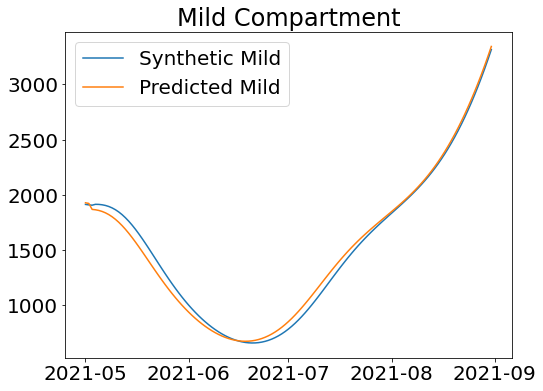

In [25]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, M_vals, label='Synthetic Mild')
plt.plot(df.loc[train_start:test_end].index.values, preds, label='Predicted Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

Text(0.5, 1.0, 'Mild Compartment')

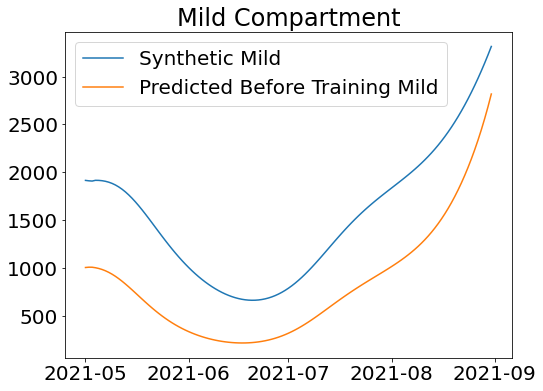

In [19]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_train), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, M_vals, label='Synthetic Mild')
plt.plot(df.loc[train_start:test_end].index.values, pre_training_preds, label='Predicted Before Training Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [23]:
import tfa.optimizers

ModuleNotFoundError: No module named 'tfa'